# Orientation representation activity during orientation tuning
We need to estimate $P(\Theta|f)$ and our previous efforts were to use the tuning block of trained mice to perform this estimate. However, the orientation representation activity presented very clear deformations during the tuning block. To estimate $P(\Theta|f)$, we need a uniform prior on the orientations $\Theta$ in the environment. In naive mice passively viewing stimuli in the tuning block, we expect such a uniform prior.

## Imports

In [1]:
%cd ../../
%load_ext autoreload
%autoreload 2

/home/jovyan/work/task-priors


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.data_compilation import NAIVE

from src.data_access import (
load_tables, 
retrieve_experiment_ids, 
retrieve_recording_day_experiment_ids, 
construct_tuning_trial_bank, 
construct_multi_day_trial_bank,
retrieve_admissible_neurons, 
)

from src.orientation_representation import (
load_all_experiments_into_memory,
construct_orientation_representation,
plot_orientation_representation,
)

In [3]:
tables = load_tables(DATASET=NAIVE)
df_celltable, df_trialtable = tables
experiment_ids = retrieve_experiment_ids(tables)

In [4]:
trial_length = 75
tuning_stimulus = np.sort(df_trialtable[df_trialtable['Block'] == 'Orientation Tuning']['Visual_Stim'].unique())
tuning_stimulus

array([  0,  30,  60,  90, 120, 150, 180, 210, 240, 270, 300, 330])

## Functionalized query

In [5]:
def stimulus_experimental_condition_query(recording_day, visual_stimulus, title, save_fig=False):
    relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
    trial_bank = construct_tuning_trial_bank(relevant_experiment_ids, recording_day, visual_stimulus, tables)
    
    admissible_neurons = retrieve_admissible_neurons(
        relevant_experiment_ids, 
        tables, 
        fit_key='Best_Fit_spikes_1',
        orientation_key='Pref_Orientation_spikes_1',
    )
    experiment_data = load_all_experiments_into_memory(trial_bank, DATASET=NAIVE, tqdm_disable=False)

    trial_matrix = construct_orientation_representation(admissible_neurons, experiment_data, trial_length, tqdm_disable=False)
    plot_orientation_representation(trial_matrix, title, save_fig=save_fig)

## Test queries

100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.12it/s]
3615it [00:00, 7346.26it/s]


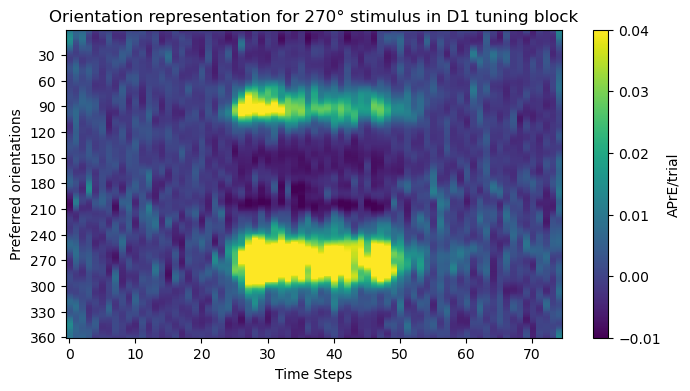

In [6]:
stimulus_experimental_condition_query('D1', 270, 'Orientation representation for 270° stimulus in D1 tuning block')

100%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.18it/s]
3836it [00:00, 7603.22it/s]


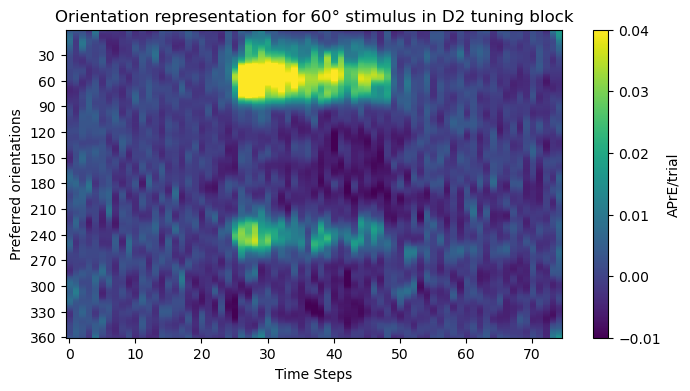

In [7]:
stimulus_experimental_condition_query('D2', 60, 'Orientation representation for 60° stimulus in D2 tuning block')

100%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.17it/s]
2851it [00:00, 7653.65it/s]


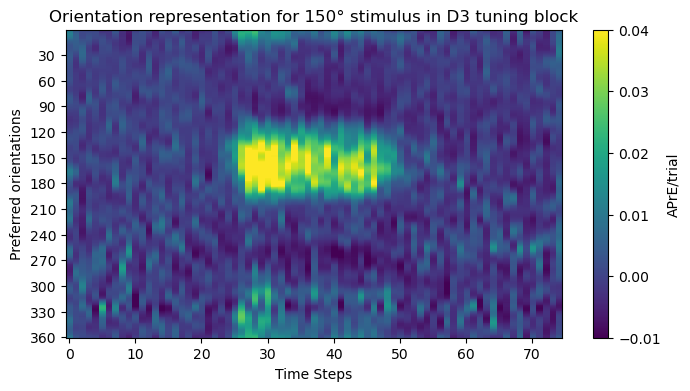

In [8]:
stimulus_experimental_condition_query('D3', 150, 'Orientation representation for 150° stimulus in D3 tuning block')

## Aggregate tuning orientation representation figure

In [9]:
def raw_orientation_representation_query(recording_day, visual_stimulus,):
    relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
    trial_bank = construct_tuning_trial_bank(relevant_experiment_ids, recording_day, visual_stimulus, tables)
    
    admissible_neurons = retrieve_admissible_neurons(
        relevant_experiment_ids, 
        tables, 
        fit_key='Best_Fit_spikes_1',
        orientation_key='Pref_Orientation_spikes_1',
    )
    experiment_data = load_all_experiments_into_memory(trial_bank, DATASET=NAIVE,)

    trial_matrix = construct_orientation_representation(admissible_neurons, experiment_data, trial_length,)
    return trial_matrix

In [10]:
behav_conds = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6',]

experimental_conditions = [[(cond, stim.item(),) for stim in tuning_stimulus] for cond in behav_conds]
experimental_conditions = [item for row in experimental_conditions for item in row]

trial_matrices = np.zeros((len(experimental_conditions), 360, trial_length,))

In [11]:
for ind, exp_cond in tqdm(enumerate(experimental_conditions)):
    trial_matrix = raw_orientation_representation_query(exp_cond[0], exp_cond[1],)
    trial_matrices[ind] = trial_matrix

72it [07:55,  6.60s/it]


In [12]:
np.save('./data/Naive_numpy_arrays/tuning_aggregated_matrices.npy', trial_matrices)

In [13]:
trial_matrices = np.load('./data/Naive_numpy_arrays/tuning_aggregated_matrices.npy',)
trial_matrices.shape

(72, 360, 75)

In [14]:
behav_col_index = {'D1':0, 'D2':1, 'D3':2, 'D4':3, 'D5':4, 'D6':5,}
orient_row_index = {0:0,  30:1,  60:2,  90:3, 120:4, 150:5, 180:6, 210:7, 240:8, 270:9, 300:10, 330:11}
    
def plot_trial_matrices(
    trial_matrices, 
    experimental_conditions, 
    num_rows=12, 
    num_cols=6, 
    degrees=np.arange(0, 360, 1), 
    trial_length=75, 
    cmap='viridis', 
    vmin=-0.01, 
    vmax=0.04, 
    save_path='./results/orientation_representations/naive_tuning_orientation_representations.png'
):
    """
    Plots trial matrices in a 12x6 grid of heatmaps.
    
    Parameters:
        trial_matrices (np.ndarray): Array of shape (72, 360, 75) containing trial data.
        experimental_conditions (list of tuples): List containing 72 tuples, each representing a condition and stimulus.
        behav_conds (list): List of behavioral condition labels (e.g., ['D1', 'D2', ..., 'D6']).
        num_rows (int): Number of rows in the subplot grid (default=12).
        num_cols (int): Number of columns in the subplot grid (default=6).
        degrees (np.ndarray): Array of degree values for y-axis ticks (default=0-359).
        trial_length (int): Length of each trial (default=75).
        cmap (str): Colormap for heatmaps (default='viridis').
        vmin (float): Minimum value for color scaling (default=-0.01).
        vmax (float): Maximum value for color scaling (default=0.04).
        save_path (str): File path to save the generated figure.
    """
    
    num_conditions = trial_matrices.shape[0]  # 72
    if num_conditions != len(experimental_conditions):
        raise ValueError("Number of trial matrices and experimental conditions must match.")
    
    # Initialize the figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 36), constrained_layout=False)
    
    # Iterate over each condition and plot
    for condition_index in tqdm(range(num_conditions), desc="Plotting Heatmaps"):
        behavioral_condition = experimental_conditions[condition_index][0]
        orientation_degree = experimental_conditions[condition_index][1]
        
        # Determine the subplot position
        col = behav_col_index[behavioral_condition]
        row = orient_row_index[orientation_degree]
        
        ax = axs[row, col]
        
        # Retrieve the corresponding trial matrix
        trial_matrix = trial_matrices[condition_index]  # Shape: (360, 75)
        
        # Plot the heatmap
        im = ax.imshow(trial_matrix, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Set subplot title
        ax.set_title(f'Condition {behavioral_condition} - {orientation_degree}°', fontsize=10)
        
        if orientation_degree != 0:
            ax.axhline(y=orientation_degree-1, color='red', linestyle='--', linewidth=0.74)  # Adjust for zero-based index
        else:
            ax.axhline(y=orientation_degree, color='red', linestyle='--', linewidth=0.74)
        
        # Customize axes
        if col != 0:
            ax.set_yticklabels([])
        else:
            # Set y-axis ticks for the first column
            y_ticks = np.arange(0, 360, 30)  # Every 30 degrees
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(y_ticks)
            ax.set_ylabel('Degrees', fontsize=12)
        
        # Hide x-axis tick labels for all subplots
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Add a single colorbar to the right of all subplots
    # Create a new axes for the colorbar
    fig.subplots_adjust(right=0.90, wspace=0.05, hspace=0.3)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    
    # Add title
    fig.suptitle('Orientation Representations for Naive Mice and Tuning Block', y=0.92, fontsize=20)
    
    # Save and display the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

Plotting Heatmaps: 100%|████████████████████████| 72/72 [00:00<00:00, 98.25it/s]


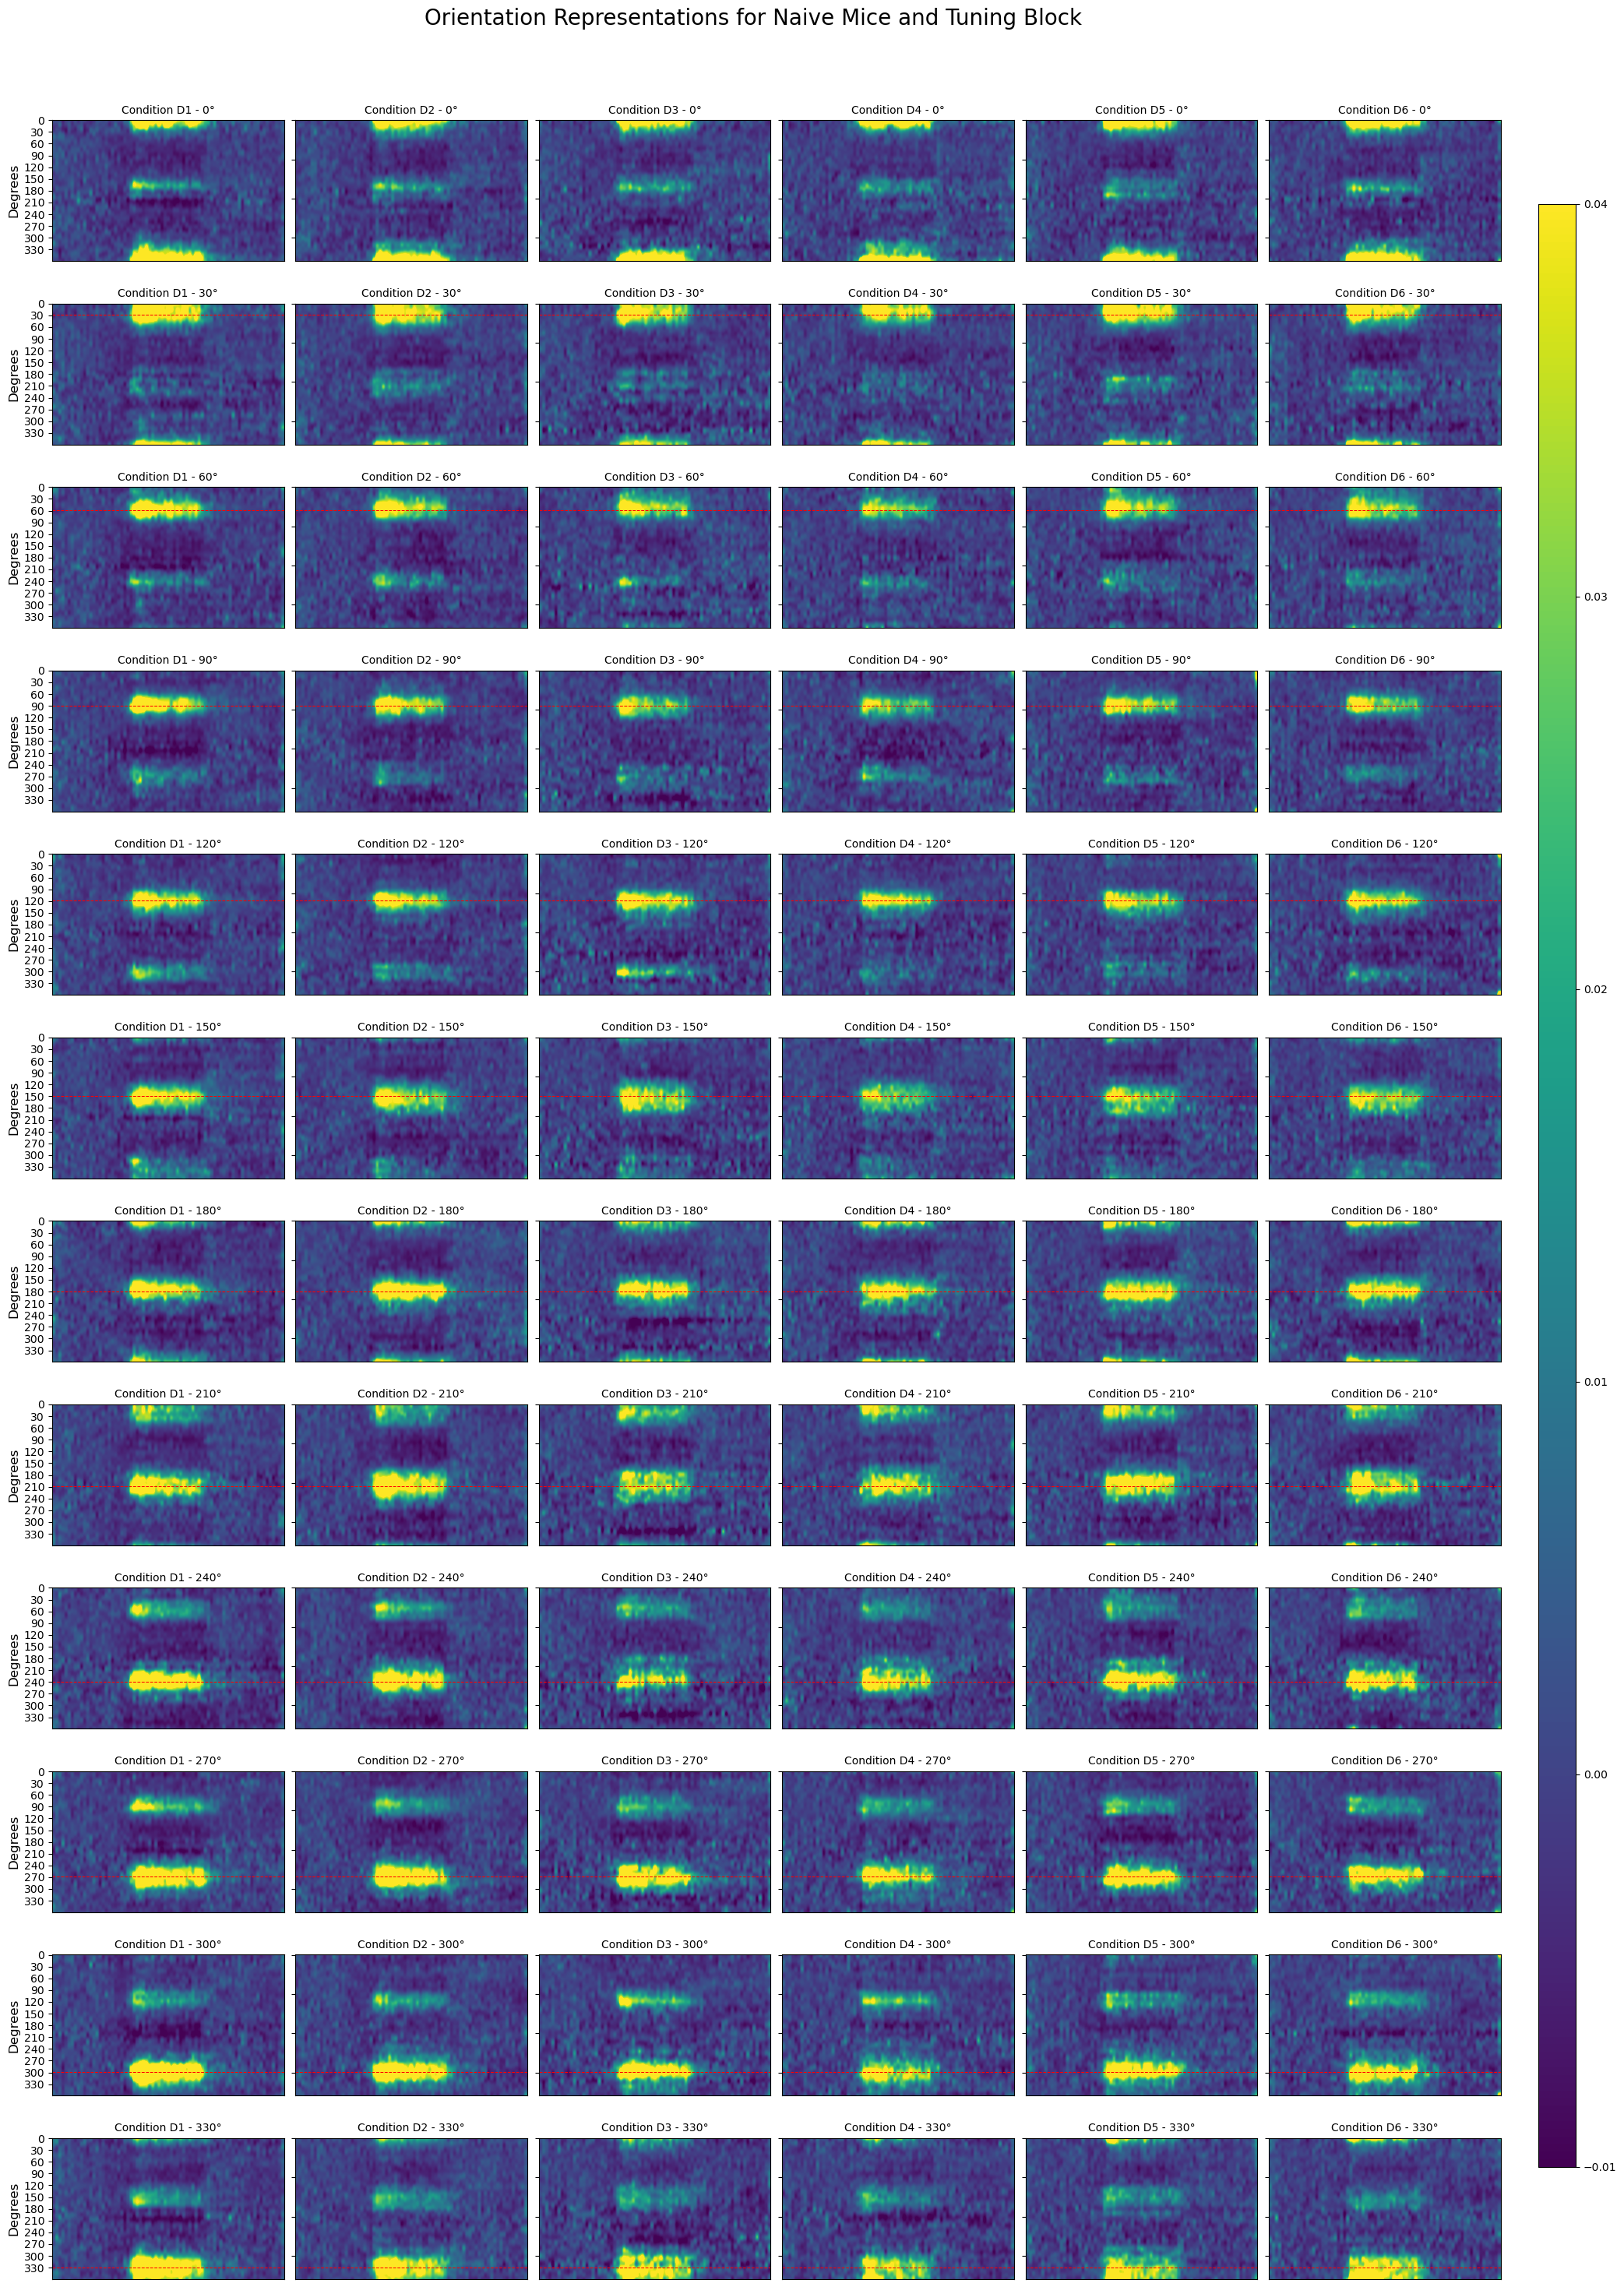

In [15]:
save_path = './results/orientation_representations/naive_tuning_orientation_representations.png'
plot_trial_matrices(
    trial_matrices=trial_matrices,
    experimental_conditions=experimental_conditions,
    num_rows=12,
    num_cols=6,
    degrees=np.arange(0, 360, 1),
    trial_length=75,
    cmap='viridis',
    vmin=-0.01,
    vmax=0.04,
    save_path=save_path
)

## Combine similar stimulus across days

In [19]:
def raw_orientation_representation_across_days_query(visual_stimulus, recording_days):
    assert isinstance(recording_days, list), 'recording_days is not list'

    trial_bank = construct_multi_day_trial_bank(recording_days, 'tuning', visual_stimulus, tables)
    relevant_experiment_ids = list(trial_bank.keys())
    
    admissible_neurons = retrieve_admissible_neurons(
        relevant_experiment_ids, 
        tables, 
        fit_key='Best_Fit_spikes_1',
        orientation_key='Pref_Orientation_spikes_1',
    )
    experiment_data = load_all_experiments_into_memory(trial_bank, DATASET=NAIVE,)

    trial_matrix = construct_orientation_representation(
        admissible_neurons, 
        experiment_data, 
        trial_length, 
    )
    return trial_matrix

In [20]:
behav_conds = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6',]

trial_matrices = np.zeros((len(tuning_stimulus), 360, trial_length,))

In [21]:
for ind, vis_stim in tqdm(enumerate(tuning_stimulus)):
    trial_matrix = raw_orientation_representation_across_days_query(vis_stim.item(), behav_conds,)
    trial_matrices[ind] = trial_matrix

12it [11:15, 56.31s/it]


In [22]:
np.save('./data/Naive_numpy_arrays/tuning_matrices_across_days.npy', trial_matrices)

In [23]:
trial_matrices = np.load('./data/Naive_numpy_arrays/tuning_matrices_across_days.npy',)
trial_matrices.shape

(12, 360, 75)

/tmp/ipykernel_29193/3741872693.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to make room for the colorbar


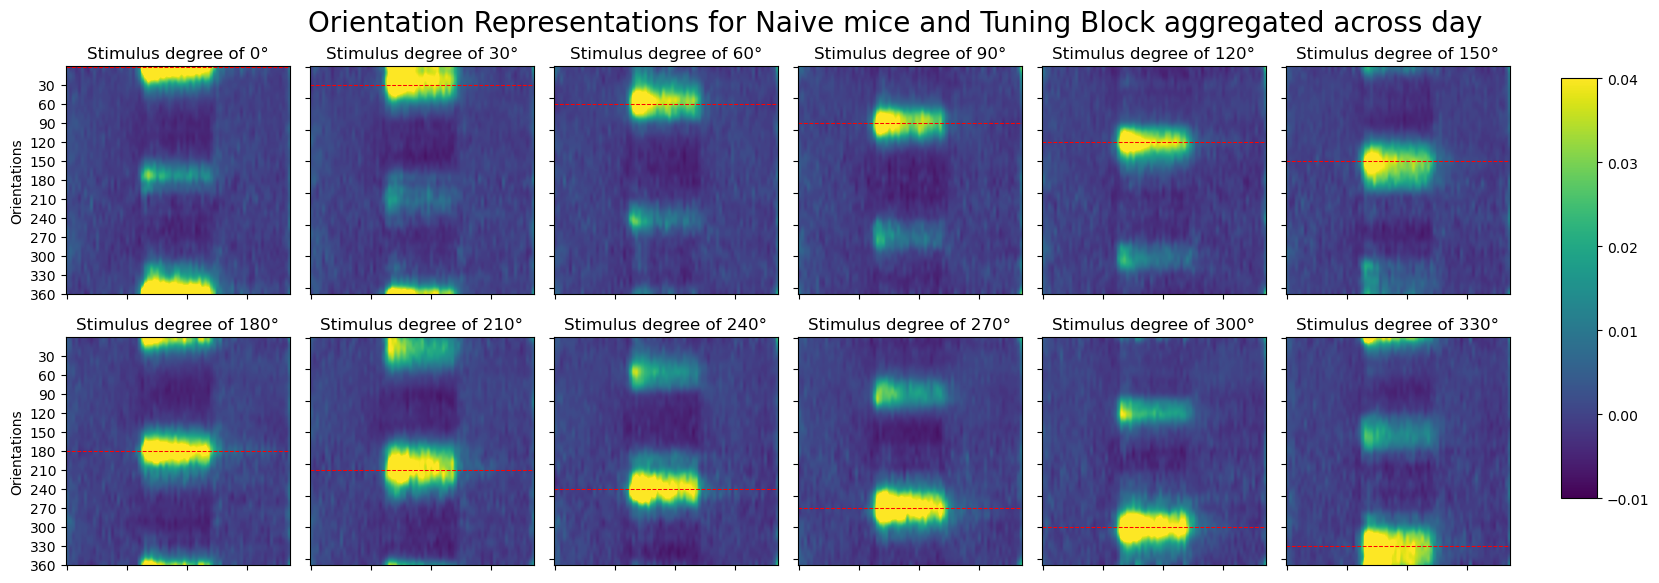

In [24]:
# Assume trial_matrices and experimental_conditions are initialized
fig, axs = plt.subplots(2, 6, figsize=(18, 6))  # Adjust the figsize if needed
axs_flat = axs.flatten()

for ind, ax in enumerate(axs_flat):
    stimulus_degree = tuning_stimulus[ind].item()
    matrix = trial_matrices[ind, :, :]  # even indices
    im1 = ax.imshow(matrix, aspect='auto', cmap='viridis', vmin=-0.01, vmax=0.04)
    ax.set_title(f'Stimulus degree of {stimulus_degree}°')
    if stimulus_degree != 0:
        ax.axhline(y=stimulus_degree-1, color='red', linestyle='--', linewidth=0.74)  # Adjust for zero-based index
    else:
        ax.axhline(y=stimulus_degree, color='red', linestyle='--', linewidth=0.74)

    # Only the first column keeps the y-axis labels
    if ind != 0 and ind != 6:
        ax.set_yticklabels([])

# Adjust y-axis ticks for the first column
y_ticks = np.arange(29, 360, 30)  # Ticks starting from 30 to 360 with steps of 30
for ax in axs[:, 0]:
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks + 1)  # Adjust tick labels for zero-based indexing
    ax.set_ylabel('Orientations')

# Hide x-tick labels for all
for ax in axs.flat:
    ax.set_xticklabels([])

# Add a colorbar to the right of the subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Adjust these parameters to fit the colorbar appropriately
fig.colorbar(im1, cax=cbar_ax)

fig.suptitle('Orientation Representations for Naive mice and Tuning Block aggregated across day', y=0.965, fontsize=20)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to make room for the colorbar
plt.savefig('./results/orientation_representations/naive_tuning_xday_orientation_representations.png')
plt.show()